In [1]:
import time
import os
import gc
import itertools
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mutual_info_score
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import missingno as msno
from keras.utils import to_categorical

%matplotlib inline

print(os.listdir("../data/"))


/home/shagrath/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['train-missings.csv', 'TechnicalTest.zip', 'ML-test-project.pdf']


In [409]:
data = pd.read_csv('../data/train-missings.csv', index_col=0)

In [410]:
data.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,target
Id,,,,,,,,,,,,,,
1,2596.0,NaN,3.0,NaN,0.0,NaN,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,5
2,2590.0,56.0,2.0,212.0,NaN,390.0,220.0,NaN,NaN,6225.0,1.0,0.0,0.0,5
3,2804.0,NaN,9.0,268.0,65.0,3180.0,NaN,238.0,NaN,6121.0,NaN,0.0,0.0,2
4,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,NaN,0.0,2
5,2595.0,45.0,NaN,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,5


## Having a look at the missing values:

As we can see all our raw features have some missing values

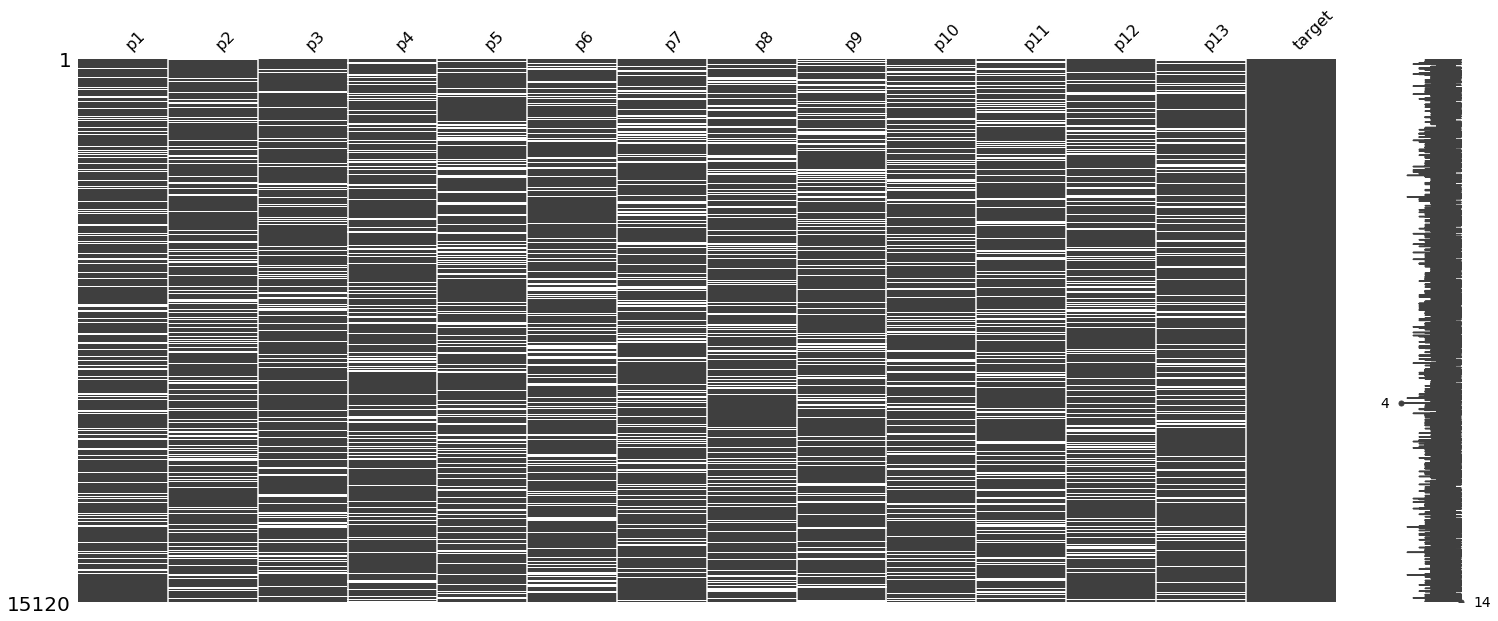

In [411]:
msno.matrix(data)

## Class labels:

In [412]:
np.unique(data['target'])

array([1, 2, 3, 4, 5, 6, 7])

In [413]:
# Classes are nicely balanced! so a simple k-fold should work fine
y.value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: target, dtype: int64

In [414]:
# Figuring out which feature could be numerical/categorical

for f in data.drop(labels=['target'], axis=1).columns:
    print('cardinality:', np.unique(data[f]).shape[0], f)

cardinality: 4597 p1
cardinality: 3293 p2
cardinality: 3076 p3
cardinality: 3428 p4
cardinality: 3444 p5
cardinality: 6048 p6
cardinality: 3140 p7
cardinality: 3221 p8
cardinality: 3293 p9
cardinality: 5493 p10
cardinality: 3091 p11
cardinality: 3091 p12
cardinality: 2924 p13


Seems numerical or categorcal with high cardinality...we are going to treat them as numerical

## Initial processing of the raw data

In [415]:
def preprocess(data):
        x = data[['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13']]  
        y = data['target']
        return x, y
    

In [416]:
x, y = preprocess(data=data)

## Setting a validation scheme:

Starting with a hold-out test set and 5-fold corss-validation

In [417]:
train_df, test_df, y_train, y_test = train_test_split(
     x, y, test_size=0.2, random_state=666) # 20 % data is hold out of traning

In [418]:
# Some auxiliary functions

def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [1, 2, 3, 4, 5, 6, 7]
    class_weight = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [419]:
folds = KFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
oof_preds = np.zeros([train_df.shape[0], 7])
error = []
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 7,
        'metric': 'multi_logloss',
        'learning_rate': 0.1,
        'subsample': 1,
        'colsample_bytree': 1,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01,
        'min_child_weight': 5,
        'n_estimators': 3000,
        'bagging_fraction': 0.3,
        'silent': -1,
        'verbose': -1,
        'max_depth': 3
    }


for fold_, (trn_, val_) in enumerate(folds.split(y_train, y_train)):
    trn_x, trn_y = train_df.iloc[trn_], y_train.iloc[trn_]
    val_x, val_y = train_df.iloc[val_], y_train.iloc[val_]
    
    
    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        verbose=100,
        early_stopping_rounds=50
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    clfs.append(clf)
    
print('OUT OF FOLD MULTI LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y_train, y_preds=oof_preds))

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.779688	valid_1's multi_logloss: 0.849792
[200]	training's multi_logloss: 0.652472	valid_1's multi_logloss: 0.785533
[300]	training's multi_logloss: 0.573774	valid_1's multi_logloss: 0.760922
[400]	training's multi_logloss: 0.510023	valid_1's multi_logloss: 0.748465
[500]	training's multi_logloss: 0.460782	valid_1's multi_logloss: 0.745034
[600]	training's multi_logloss: 0.419196	valid_1's multi_logloss: 0.744367
Early stopping, best iteration is:
[557]	training's multi_logloss: 0.436629	valid_1's multi_logloss: 0.742255
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.776686	valid_1's multi_logloss: 0.868924
[200]	training's multi_logloss: 0.648671	valid_1's multi_logloss: 0.808689
[300]	training's multi_logloss: 0.568588	valid_1's multi_logloss: 0.791675
[400]	training's multi_logloss: 0.505245	valid_1's multi_logloss: 0.778578
[500]	training's

## Our initial out of fold error is 0.76129

In [420]:
test_predictions = np.zeros([test_df.shape[0], 7])
for clf in clfs:
    test_predictions += clf.predict_proba(test_df)
test_predictions = test_predictions / 5

In [421]:
print('HOLD OUT MULTI LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y_test, y_preds=test_predictions))

HOLD OUT MULTI LOG LOSS : 0.69653 


## Our initial holdout error is 0.69653

In [422]:
# Visualizing the confusion matrix

def plot_confusion_matrix(cm, classes=[1, 2, 3, 4, 5, 6, 7],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [423]:
# Compute confusion matrix
unique_y = np.unique(y_train)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y_train])
y_categorical = to_categorical(y_map)

cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

Normalized confusion matrix
[[5.45e-01 2.01e-01 1.61e-02 4.59e-03 4.82e-02 2.18e-02 1.63e-01]
 [2.48e-01 4.92e-01 2.95e-02 3.47e-03 1.44e-01 4.63e-02 3.65e-02]
 [3.55e-03 1.42e-02 5.85e-01 9.40e-02 4.61e-02 2.46e-01 1.06e-02]
 [2.92e-03 5.85e-04 4.62e-02 9.03e-01 5.85e-04 4.39e-02 2.92e-03]
 [1.69e-02 8.43e-02 4.76e-02 6.97e-03 7.91e-01 3.54e-02 1.80e-02]
 [1.14e-02 7.44e-03 1.90e-01 6.41e-02 4.46e-02 6.75e-01 6.87e-03]
 [9.80e-02 1.99e-02 7.98e-03 2.85e-03 2.11e-02 9.69e-03 8.40e-01]]


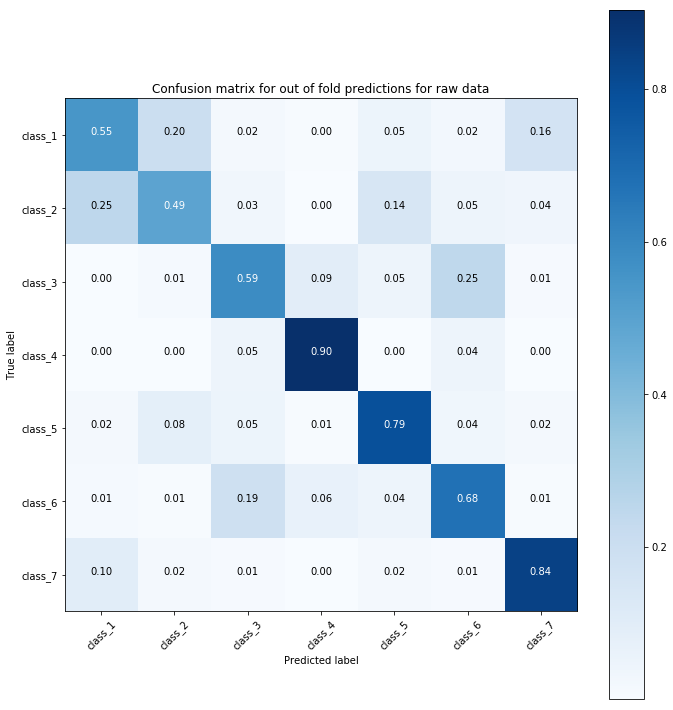

In [424]:
# Plot non-normalized confusion matrix

class_names = ['class_' + str(i) for i in range(1, 8)]
plt.figure(figsize=(10,10))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix for out of fold predictions for raw data')


In [425]:
# As we can see, there is room for improvements for many classes

## Let's improve our model (very basic feature engineering, parameter optimzation, feature selection, imputation,...)

In [426]:
# No traditional nan impuattion worked, by mean,
#  median, max, seeting an extreme value... so leave it as it is. Seem LGBM handles nans more efficiently

### Simple seature selection using a filter method (mutual information of a feature and ys)

In [427]:
# Creating interation features and prunning the non informative ones
met = []
mis = []
features = []
for f in train_df.columns:
    for g in train_df.columns:
        if (f, g) not in met and f != g:
            mis.append(mutual_info_score(train_df[f] / train_df[g], y_train))
            features.append((f, g, mutual_info_score(train_df[f] / train_df[g], y_train)))
            print(f, g, mutual_info_score(train_df[f] / train_df[g], y_train))
            met = met + [(f, g), (g, f)]

p1 p2 1.926687839261466
p1 p3 1.8645126335940791
p1 p4 1.8186830555411029
p1 p5 1.8016332493744698
p1 p6 1.942771581387322
p1 p7 1.9196586915140277
p1 p8 1.9132926031807567
p1 p9 1.9203084448485006
p1 p10 1.9417401123686315
p1 p11 0.9612549609940627
p1 p12 0.7401067549230782
p1 p13 1.0856025318967537
p2 p3 1.4362003730496133
p2 p4 1.614496007863357
p2 p5 1.641267802416166
p2 p6 1.9022445929450142
p2 p7 1.5527975085697256
p2 p8 1.619539709901825
p2 p9 1.6186681767065396
p2 p10 1.9107637367676045
p2 p11 0.8802214259409527
p2 p12 0.7433400006250102
p2 p13 0.8606371541893689
p3 p4 1.2609686657901258
p3 p5 1.2691737475862919
p3 p6 1.8026145418439765
p3 p7 1.1894115702991859
p3 p8 1.12055345311703
p3 p9 1.255021834312909
p3 p10 1.788919479751091
p3 p11 0.8377535841877115
p3 p12 0.7271760669837332
p3 p13 0.7755177160932749
p4 p5 1.540148109600262
p4 p6 1.7783129109062086
p4 p7 1.5432217804876822
p4 p8 1.5179376568071274
p4 p9 1.5764269086786795
p4 p10 1.7758868014148814
p4 p11 0.9576589768338

In [428]:
for f, g, mi in np.array(features)[np.argsort(-np.array(mis))[0:]]:
    train_df[f + '/' + g] = train_df[f] / train_df[f]

/home/shagrath/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [429]:
for f in train_df.columns:
     if mutual_info_score(train_df[f], y_train) < 0.4: 
        print(mutual_info_score(train_df[f], y_train), f)
        del train_df[f]

0.38446632309688167 p1/p6
0.38446632309688167 p1/p10
0.38446632309688167 p1/p2
0.38446632309688167 p1/p9
0.38446632309688167 p1/p7
0.38446632309688167 p1/p8
0.38212284671024377 p7/p10
0.39395646112765226 p2/p10
0.3973869386214486 p8/p10
0.39395646112765226 p2/p6
0.3972608549829929 p9/p10
0.38446632309688167 p1/p3
0.38446632309688167 p1/p4
0.38863601879613957 p3/p6
0.38446632309688167 p1/p5
0.38863601879613957 p3/p10
0.39395646112765226 p2/p5
0.39395646112765226 p2/p8
0.39395646112765226 p2/p9
0.39395646112765226 p2/p4
0.3973869386214486 p8/p9
0.39395646112765226 p2/p7
0.38212284671024377 p7/p8
0.38212284671024377 p7/p9
0.39395646112765226 p2/p3
0.38863601879613957 p3/p5
0.38863601879613957 p3/p4
0.38863601879613957 p3/p9
0.38863601879613957 p3/p7
0.38863601879613957 p3/p8
0.38446632309688167 p1/p13
0.3836532620200714 p10/p13
0.3836532620200714 p10/p11
0.38446632309688167 p1/p11
0.39395646112765226 p2/p11
0.3972608549829929 p9/p11
0.39395646112765226 p2/p13
0.3973869386214486 p8/p11
0.3

In [430]:
from scipy import stats
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier
from scipy.stats import ranksums
## Parameter tuning with Baysean optimization (could take hours to run)

def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {}
    params["num_leaves"] = int(num_leaves)
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(max_depth)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    cv_result = lgb_cv(**params)
    return cv_result

def lgb_cv(num_leaves, feature_fraction, bagging_fraction, max_depth,
           lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    
    print(num_leaves)
    folds = KFold(n_splits=5, shuffle=True, random_state=1)
    clfs = []
    oof_preds = np.zeros([train_df.shape[0], 7])
    lgb_params = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class': 7,
            'metric': 'multi_logloss',
            'learning_rate': 0.03,
            'subsample': .9,
            'num_leaves': num_leaves,
            'colsample_bytree': feature_fraction,
            'reg_alpha': lambda_l1,
            'reg_lambda': lambda_l2,
            'min_split_gain': min_split_gain,
            'min_child_weight': min_child_weight,
            'n_estimators': 30000,
            'bagging_fraction': bagging_fraction,
            'silent': -1,
            'verbose': -1,
            'max_depth': max_depth
        }


    for fold_, (trn_, val_) in enumerate(folds.split(y_train, y_train)):
        trn_x, trn_y = train_df.iloc[trn_], y_train.iloc[trn_]
        val_x, val_y = train_df.iloc[val_], y_train.iloc[val_]
        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            verbose=-1,
            early_stopping_rounds=50
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        clfs.append(clf)

    return multi_weighted_logloss(y_true=y_train, y_preds=oof_preds)


gb_bo = BayesianOptimization(lgb_eval, {'num_leaves': (18, 40),
                                        'feature_fraction': (0.02, 0.2),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (-1,8),
                                        'lambda_l1': (0, 100),
                                        'lambda_l2': (0, 100),
                                        'min_split_gain': (0.0, 0.5),
                                        'min_child_weight': (10, 100)}, 
                                        random_state=0)
            
            
gb_bo.maximize(init_points=15, n_iter=10) # set n_iter = 1000 and wait






Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
23
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6126]	training's multi_logloss: 0.810223	valid_1's multi_logloss: 0.872698
Training until validation scores don't improve for 50 rounds.


KeyboardInterrupt: 

In [ ]:
# We can do paramter tuning with trial and error (to dot it faster.. can't wait for Baysean optimzation to finish ;)

# some important parameters: 
# * max_depth
# * reg_alpha
# * reg_lambda
# * colsample_bytree
# * and learning rate

In [431]:
folds = KFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
oof_preds = np.zeros([train_df.shape[0], 7])
error = []
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 7,
        'metric': 'multi_logloss',
        'learning_rate': 0.03,
        'subsample': .85,
        'colsample_bytree': 0.65,
        'reg_alpha': .01,
        'reg_lambda': 1,
        'min_split_gain': 0.01,
        'min_child_weight': 5,
        'n_estimators': 3000,
        'bagging_fraction': 0.3,
        'silent': -1,
        'verbose': -1,
        'max_depth': -1
    }


for fold_, (trn_, val_) in enumerate(folds.split(y_train, y_train)):
    trn_x, trn_y = train_df.iloc[trn_], y_train.iloc[trn_]
    val_x, val_y = train_df.iloc[val_], y_train.iloc[val_]
    
    
    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        verbose=100,
        early_stopping_rounds=50
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    clfs.append(clf)
    
print('OUT OF FOLD MULTI LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y_train, y_preds=oof_preds))

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.818961	valid_1's multi_logloss: 0.94265
[200]	training's multi_logloss: 0.586519	valid_1's multi_logloss: 0.791208
[300]	training's multi_logloss: 0.472805	valid_1's multi_logloss: 0.748651
[400]	training's multi_logloss: 0.396545	valid_1's multi_logloss: 0.73143
[500]	training's multi_logloss: 0.339086	valid_1's multi_logloss: 0.722782
[600]	training's multi_logloss: 0.293993	valid_1's multi_logloss: 0.720113
Early stopping, best iteration is:
[560]	training's multi_logloss: 0.310904	valid_1's multi_logloss: 0.719431
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.815137	valid_1's multi_logloss: 0.955376
[200]	training's multi_logloss: 0.583874	valid_1's multi_logloss: 0.806777
[300]	training's multi_logloss: 0.472093	valid_1's multi_logloss: 0.766164
[400]	training's multi_logloss: 0.396376	valid_1's multi_logloss: 0.750944
[500]	training's m

In [432]:
for f, g, mi in np.array(features)[np.argsort(-np.array(mis))[0:]]:
    test_df[f + '/' + g] = test_df[f] / test_df[f]

/home/shagrath/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [433]:
test_predictions = np.zeros([test_df.shape[0], 7])
for clf in clfs:
    test_predictions += clf.predict_proba(test_df[train_df.columns])
test_predictions = test_predictions / 5

In [434]:
print('HOLD OUT MULTI LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y_test, y_preds=test_predictions))

HOLD OUT MULTI LOG LOSS : 0.67602 


In [435]:
# got about 0.02 improvement

Normalized confusion matrix
[[5.46e-01 2.13e-01 1.26e-02 3.44e-03 4.99e-02 2.18e-02 1.53e-01]
 [2.34e-01 5.10e-01 3.01e-02 2.90e-03 1.41e-01 4.28e-02 3.94e-02]
 [3.55e-03 1.18e-02 6.11e-01 8.81e-02 4.49e-02 2.33e-01 8.27e-03]
 [5.85e-04 5.85e-04 4.50e-02 9.11e-01 1.17e-03 3.92e-02 2.92e-03]
 [1.57e-02 8.02e-02 4.53e-02 5.81e-03 8.05e-01 3.14e-02 1.69e-02]
 [8.59e-03 6.30e-03 1.94e-01 5.90e-02 4.52e-02 6.79e-01 8.01e-03]
 [8.72e-02 1.71e-02 1.03e-02 3.42e-03 2.22e-02 9.69e-03 8.50e-01]]


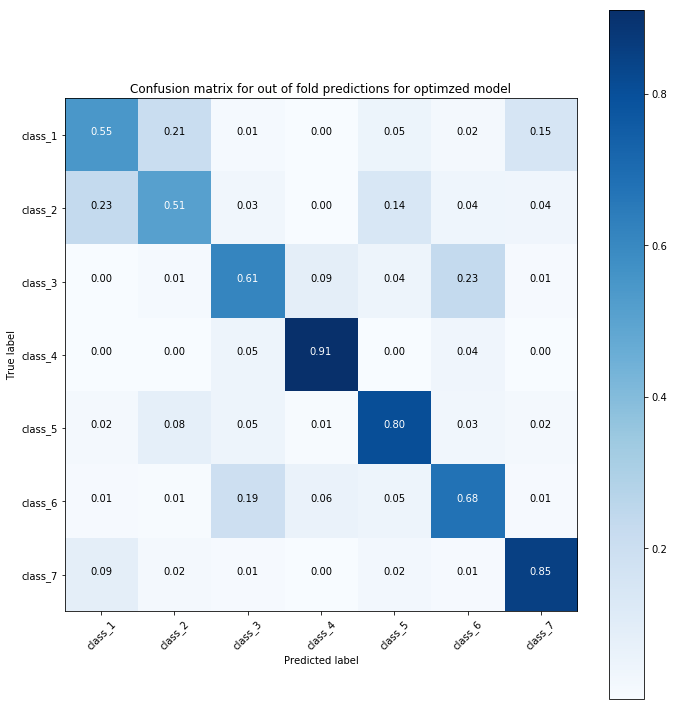

In [436]:
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

class_names = ['class_' + str(i) for i in range(1, 8)]
plt.figure(figsize=(10,10))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix for out of fold predictions for optimzed model')


In [437]:
# We can see some improvements in our out of fold predictions as well

## Saving the model

In [438]:
import pickle

with open('all_I_need.pickle', 'wb') as handle:
    pickle.dump({'models': clfs, 'features': features, 'selected_features': train_df.columns}, handle, protocol=pickle.HIGHEST_PROTOCOL)